In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [143]:
pd.set_option('display.max_rows', None)

'''
We have seven csv files in total that contains data on fossil fuel demand, net demand, solar, 
and wind generation. 

We convert all the csv files into individual dataframes. Concactenate it into one large data frame
to feed into the ML model
'''
# Create an empty list to store each processed DataFrame
dfs = []

# Starting date
start_date = datetime.strptime('09/16/2023', '%m/%d/%Y')

# Loop through each file number
for i in range(1, 8):  # This will loop from 1 to 7 inclusive
    
    # Get the appropriate date string for the current iteration
    current_date_str = (start_date + timedelta(days=i-1)).strftime('%m/%d/%Y')
    
    # Construct the old column name using the current date string
    old_column_name = f'Net Demand {current_date_str}undefined'
    
    filename = f"CAISO{i}.csv"
    data = pd.read_csv(filename)
    
    # Rename the column
    data.rename(columns={old_column_name: 'Time'}, inplace=True)
    
    data.set_index("Time", inplace=True)
    transposed_data = data.T
    dfs.append(transposed_data)

# Concatenate all DataFrames vertically
final_data = pd.concat(dfs, axis=0)

# Display the final concatenated DataFrame (or you can save it or perform other operations)
final_data = final_data[['Demand', 'Net demand', 'Solar without hybrids', 'Wind without hybrids']]



In [144]:
'''
Feed the XGBoost model our data to predict net demand
Tune the parameters of the model to optimize the RMSE of the model
Create a dataframe that contains actual vs predicted value of net demand to plot graph

'''

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

copy_df = final_data.copy()

y = copy_df["Net demand"]
X = copy_df[['Demand', 'Net demand', 'Solar without hybrids', 'Wind without hybrids']]
tscv = TimeSeriesSplit(n_splits=int(0.3*final_data.shape[0]), test_size=1)

all_y_test = []
all_y_pred = []
dfs = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=8, early_stopping_rounds=2)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = model.predict(X_test)
    
    temp_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })
    dfs.append(temp_df)

    all_y_test.extend(y_test.values)
    all_y_pred.extend(y_pred)

# Compute RMSE after collecting all y_test and y_pred values
rmse = mean_squared_error(all_y_test, all_y_pred, squared=False)
print(f"RMSE over all iterations: {rmse}")


RMSE over all iterations: 43.25231882311023


In [145]:
final_df = pd.concat(dfs, axis=0)
graph = final_df.reset_index(drop=True)
graph

,Actual,Predicted
0,24009.0,24003.453125
1,23817.0,23728.472656
2,23666.0,23611.441406
3,23520.0,23511.560547
4,23369.0,23337.359375
5,23186.0,23185.748047
6,23068.0,23068.375000
7,22922.0,22877.755859
8,22844.0,22844.773438
9,22730.0,22693.593750


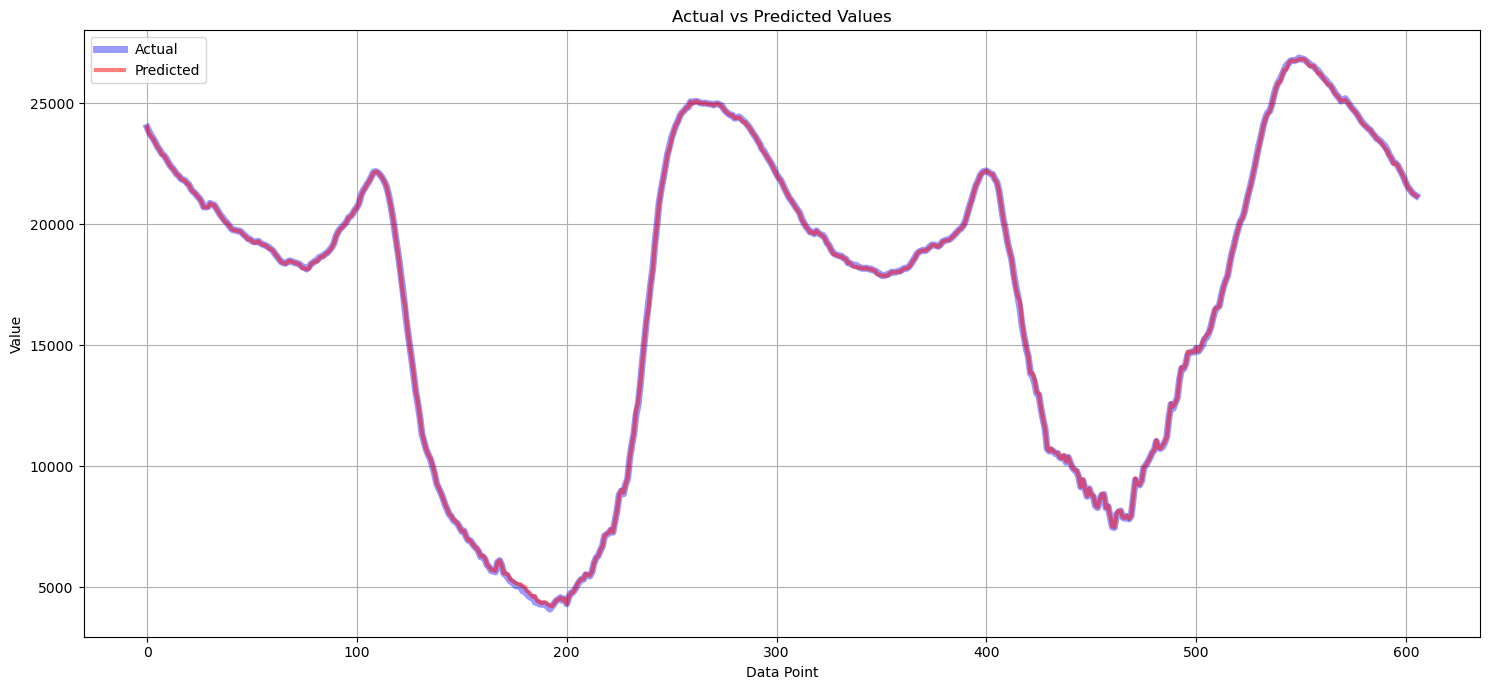

In [157]:
'''
Plot graph
'''
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(graph['Actual'], label='Actual', color='blue',linewidth=5, alpha=0.4)
plt.plot(graph['Predicted'], label='Predicted', color='red',linewidth=3, alpha=0.5)

# Providing titles and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(loc='upper left')

plt.tight_layout()
plt.grid(visible=True)
plt.show()
